In [1]:
import os
import pandas as pd
import tensorflow as tf
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional, Conv1D, GlobalMaxPooling1D, Concatenate, AdditiveAttention
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import AdditiveAttention
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from utils import eval, eval_training, get_train_test_data, save_for_evaluation, process_train_test_data
import re
import numpy as np
import spacy
from gensim.models import Word2Vec
from transformers import BertTokenizer, TFBertModel


os.environ['TF_NUM_INTEROP_THREADS'] = '10'
os.environ['TF_NUM_INTRAOP_THREADS'] = '10'

# Configure TensorFlow session for multi-threading
tf.config.threading.set_inter_op_parallelism_threads(10)
tf.config.threading.set_intra_op_parallelism_threads(10)
# Ensure TensorFlow is using the Metal backend
gpu = len (tf.config.list_physical_devices ('GPU'))>0
print ("GPU is", "available" if gpu else "NOT AVAILABLE")

GPU is available


# Data preparation

label
other-minor                 9805
meniskus-urgent             9312
cruciate-ligament-urgent    2388
meniskus-minor              1664
cruciate-ligament-minor      355
Name: count, dtype: int64


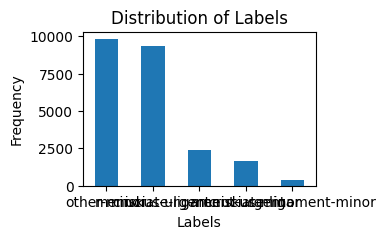

In [2]:
data_label = "data"
predict_label = "label"
balanced = False
labels = None
class_weights = False
sample_weights = False
df_train = pd.read_csv('../data/data_train.csv')
df_valid = pd.read_csv('../data/data_valid.csv')
df_test = pd.read_csv('../data/data_test.csv')

train_padded, valid_padded, test_padded, train_labels, valid_labels, test_labels, label_encoder, num_classes, max_length, word_index, class_weights, sample_weights = process_train_test_data(df_train, df_valid, df_test, data_label, predict_label, lables=labels, class_weights=class_weights, sample_weights=sample_weights)

# Model parameters

In [3]:
model_name = "lr_scheduler"

In [4]:
from utils import get_standard_parameters

optimizer, loss, metrics, early_stopping_callback, embedding_dim, lstm_units, epochs, batch_size = get_standard_parameters()

def lr_schedule(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * np.exp(-0.1)
    
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(schedule=lr_schedule)


2024-07-30 07:41:27.146425: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2024-07-30 07:41:27.146470: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-07-30 07:41:27.146494: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-07-30 07:41:27.146527: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-30 07:41:27.146559: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Model definition and training

In [5]:
# Define the input layer
input_text = Input(shape=(max_length,), dtype='int32', name='text_input')

# Embedding layer
embedding = Embedding(input_dim=len(word_index), output_dim=embedding_dim)(input_text)

# Two LSTM layers
x = Bidirectional(LSTM(units=lstm_units, return_sequences=True))(embedding)
x = Dropout(0.5)(x)
x = Bidirectional(LSTM(units=lstm_units))(x)

# Output layer
output = Dense(num_classes, activation='softmax')(x)

# Define the model
model = Model(inputs=input_text, outputs=output)

# Compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [6]:
import tensorflow as tf
import numpy as np

def cyclic_learning_rate(epoch, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular'):
    cycle = np.floor(1 + epoch / (2 * step_size))
    x = np.abs(epoch / step_size - 2 * cycle + 1)
    if mode == 'triangular':
        return base_lr + (max_lr - base_lr) * np.maximum(0, (1 - x))
    elif mode == 'triangular2':
        return base_lr + (max_lr - base_lr) * np.maximum(0, (1 - x)) / float(2**(cycle-1))
    elif mode == 'exp_range':
        return base_lr + (max_lr - base_lr) * np.maximum(0, (1 - x)) * (0.999**(epoch))
    else:
        raise ValueError('Invalid mode: {}'.format(mode))

# Example usage with LearningRateScheduler
clr = tf.keras.callbacks.LearningRateScheduler(lambda epoch: cyclic_learning_rate(epoch, base_lr=10**-3.5, max_lr=0.2, step_size=2000, mode='triangular'))


2024-07-30 07:41:27.937753: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


736/736 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - accuracy: 0.3959 - auc: 0.7492 - f1_score: 0.1803 - loss: 1.4424  


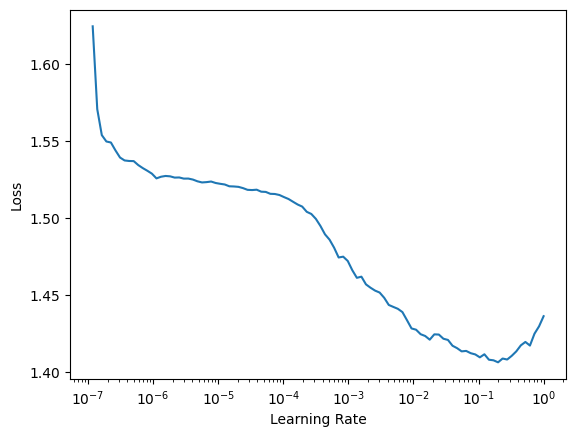

In [7]:
from keras import backend as K
class LearningRateRangeTest(tf.keras.callbacks.Callback):
    def __init__(self, start_lr=1e-2, end_lr=1e-1, num_iter=100):  # Adjusted range
        super().__init__()
        self.start_lr = start_lr
        self.end_lr = end_lr
        self.num_iter = num_iter
        self.iteration = 0
        self.history = []
        self.lr_mult = (end_lr / start_lr) ** (1 / num_iter)

    def on_batch_end(self, batch, logs=None):
        self.iteration += 1
        lr = self.start_lr * (self.lr_mult ** self.iteration)
        optimizer.learning_rate.assign(lr)
        self.history.append((lr, logs['loss']))

        if self.iteration >= self.num_iter:
            self.model.stop_training = True

# Run the learning rate range test
lr_test = LearningRateRangeTest(start_lr=1e-7, end_lr=1, num_iter=100)
model.fit(train_padded, train_labels, epochs=1, batch_size=32, callbacks=[lr_test])

# Plot the learning rate range test results
import matplotlib.pyplot as plt

lrs, losses = zip(*lr_test.history)
plt.plot(lrs, losses)
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.show()


In [8]:
import pandas as pd

# Create a DataFrame and save to CSV
df = pd.DataFrame(lr_test.history, columns=['Learning Rate', 'Loss'])
df.to_csv('lr_loss_data.csv', index=False)


In [9]:
from tensorflow.keras.callbacks import LearningRateScheduler
history = model.fit(train_padded, train_labels, epochs=epochs, batch_size=batch_size,
                    validation_data=(valid_padded, valid_labels), callbacks=[early_stopping_callback, clr])

Epoch 1/15
736/736 ━━━━━━━━━━━━━━━━━━━━ 128s 175ms/step - accuracy: 0.3878 - auc: 0.7021 - f1_score: 0.1596 - loss: 2.4519 - val_accuracy: 0.4152 - val_auc: 0.7651 - val_f1_score: 0.1754 - val_loss: 1.4908 - learning_rate: 3.1623e-04
Epoch 2/15
736/736 ━━━━━━━━━━━━━━━━━━━━ 128s 173ms/step - accuracy: 0.3981 - auc: 0.7447 - f1_score: 0.1932 - loss: 1.6262 - val_accuracy: 0.4200 - val_auc: 0.7724 - val_f1_score: 0.1627 - val_loss: 1.3830 - learning_rate: 4.1607e-04
Epoch 3/15
736/736 ━━━━━━━━━━━━━━━━━━━━ 130s 177ms/step - accuracy: 0.4058 - auc: 0.7544 - f1_score: 0.1911 - loss: 1.4877 - val_accuracy: 0.4218 - val_auc: 0.7823 - val_f1_score: 0.1745 - val_loss: 1.3078 - learning_rate: 5.1591e-04
Epoch 4/15
736/736 ━━━━━━━━━━━━━━━━━━━━ 131s 178ms/step - accuracy: 0.4067 - auc: 0.7676 - f1_score: 0.1879 - loss: 1.3909 - val_accuracy: 0.4231 - val_auc: 0.7859 - val_f1_score: 0.1647 - val_loss: 1.2690 - learning_rate: 6.1575e-04
Epoch 4: early stopping
Restoring model weights from the end of 

246/246 ━━━━━━━━━━━━━━━━━━━━ 13s 52ms/step


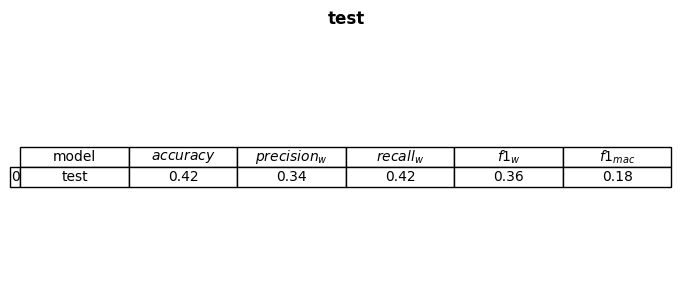

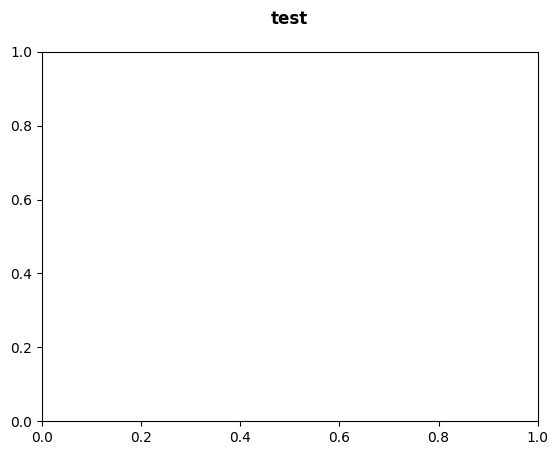

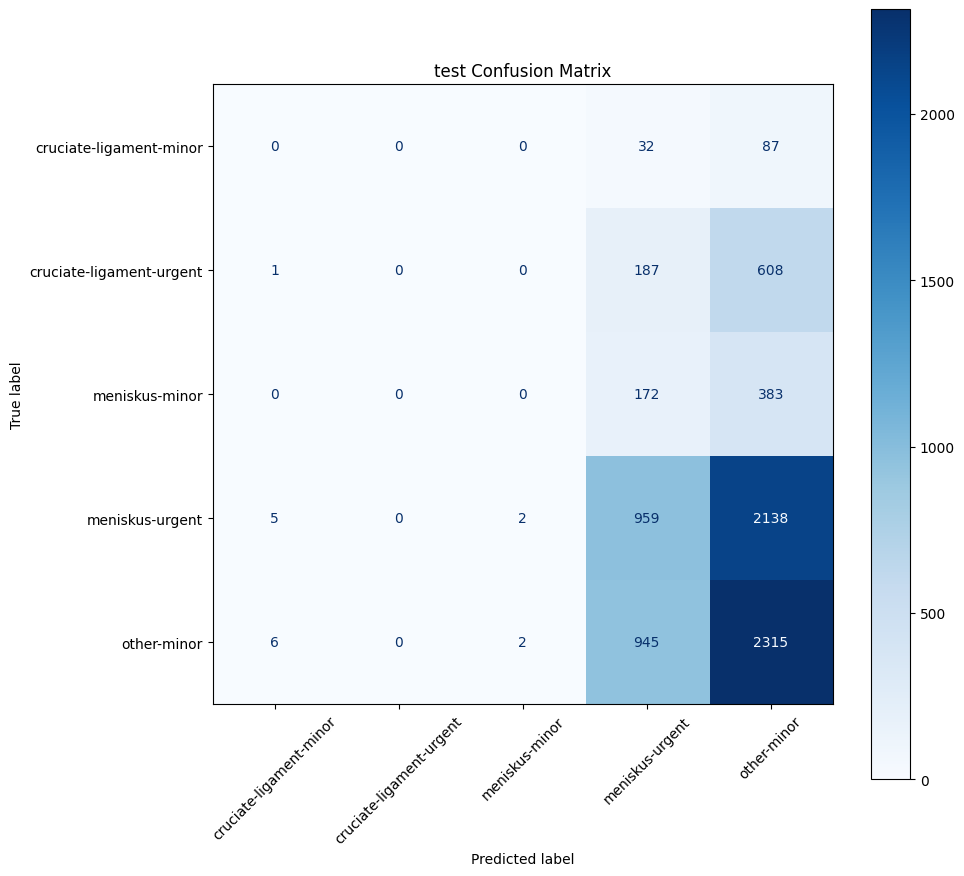

,model,$accuracy$,$precision_{w}$,$recall_{w}$,$f1_{w}$,$f1_{mac}$
0,test,0.42,0.34,0.42,0.36,0.18


In [10]:
eval(model, test_padded, test_labels, label_encoder, "test")

In [11]:
save_for_evaluation(model, history, model_name, test_padded, test_labels, label_encoder)

Model saved to ../models/lstm/lr_scheduler/lr_scheduler.h5
Data saved


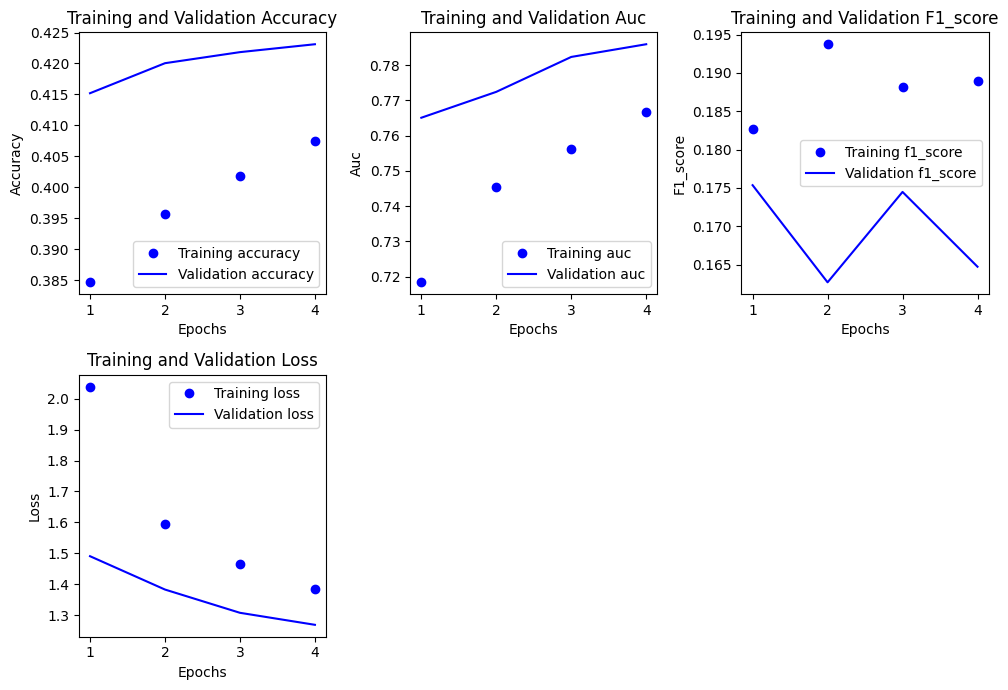

In [12]:
eval_training(history, metrics)

246/246 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step


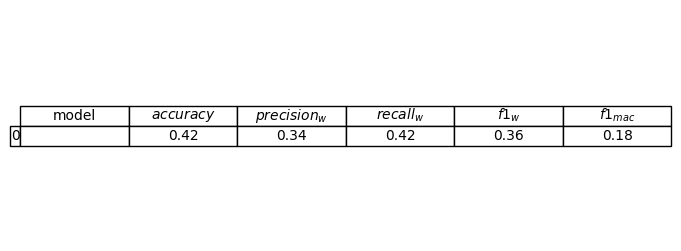

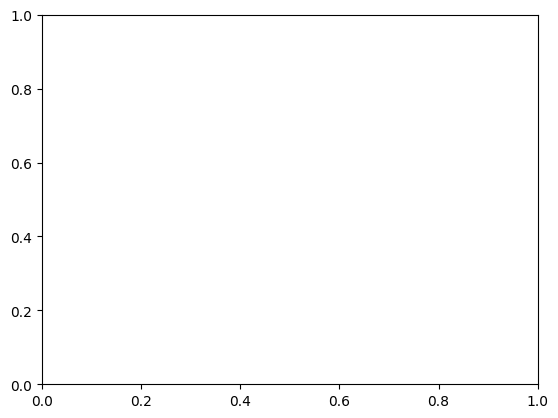

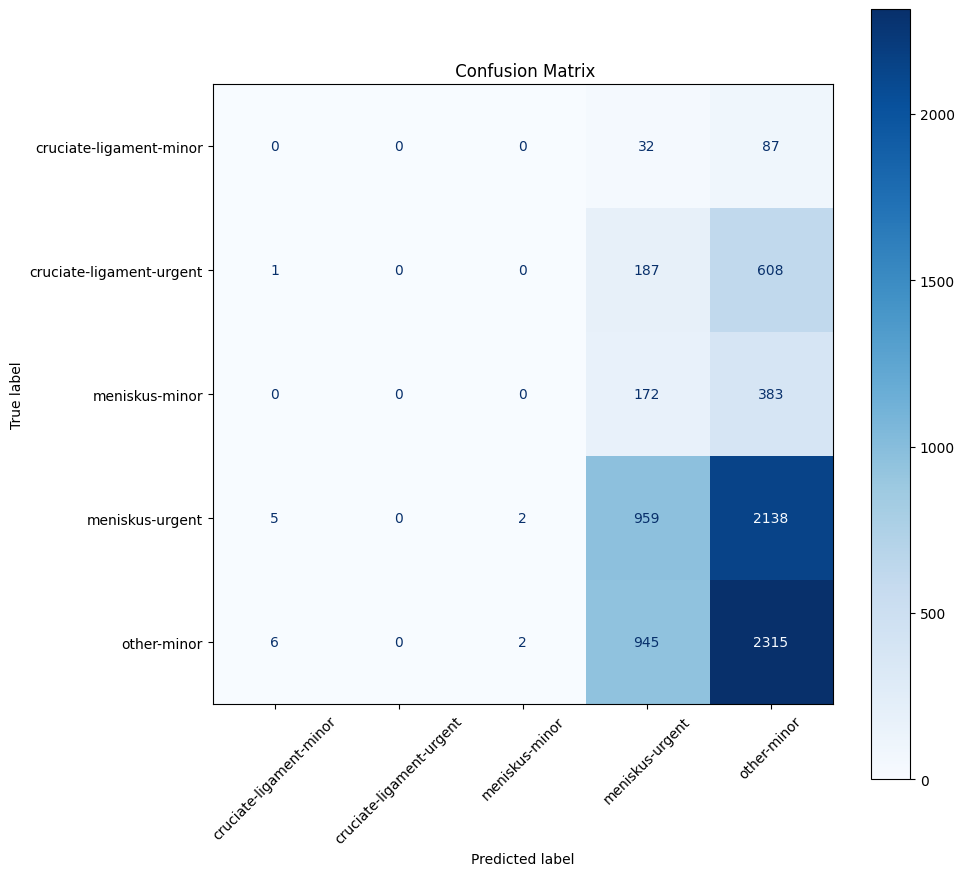

ValueError: Cannot embed the '../reports/lstm/.png' image format

In [13]:
eval(model, test_padded, test_labels, label_encoder)

In [ ]:
import plotly.graph_objs as go

def plot_model_structure(model):
    layers = [layer for layer in model.layers]
    layer_names = [layer.name for layer in layers]
    layer_types = [type(layer).__name__ for layer in layers]
    output_shapes = [str(layer.output_shape) for layer in layers]

    fig = go.Figure()

    for i, layer in enumerate(layers):
        fig.add_trace(go.Scatter(
            x=[i],
            y=[0],
            mode='markers+text',
            text=[f'{layer_names[i]}<br>{layer_types[i]}<br>{output_shapes[i]}'],
            textposition='bottom center'
        ))

    fig.update_layout(
        title='Model Structure',
        xaxis=dict(
            tickmode='array',
            tickvals=list(range(len(layers))),
            ticktext=layer_names
        ),
        showlegend=False
    )
    fig.show()

# Plot the model structure
plot_model_structure(model)


AttributeError: 'InputLayer' object has no attribute 'output_shape'

In [ ]:
import pydot
import graphviz

# Check pydot
print(pydot.find_graphviz())

# Check graphviz
print(graphviz.__version__)

AttributeError: module 'pydot' has no attribute 'find_graphviz'

NameError: name 'model' is not defined